# Load Simulation Data

In [36]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.animation
%matplotlib notebook

In [37]:
horizon = 100
sim_dir = '100'

In [38]:
hand_poses = np.load(os.path.join(sim_dir, 'hand_poses.npy'))
pts = np.load(os.path.join(sim_dir, 'cloth_points.npy'))
mount = np.load(os.path.join(sim_dir, 'gripper_sites.npy'))[0] - hand_poses[0, :3, 3]
mount_g = np.zeros((4, 4))
mount_g[:3, 3] = mount
hand_poses = hand_poses + mount_g

## World Coords

<IPython.core.display.Javascript object>


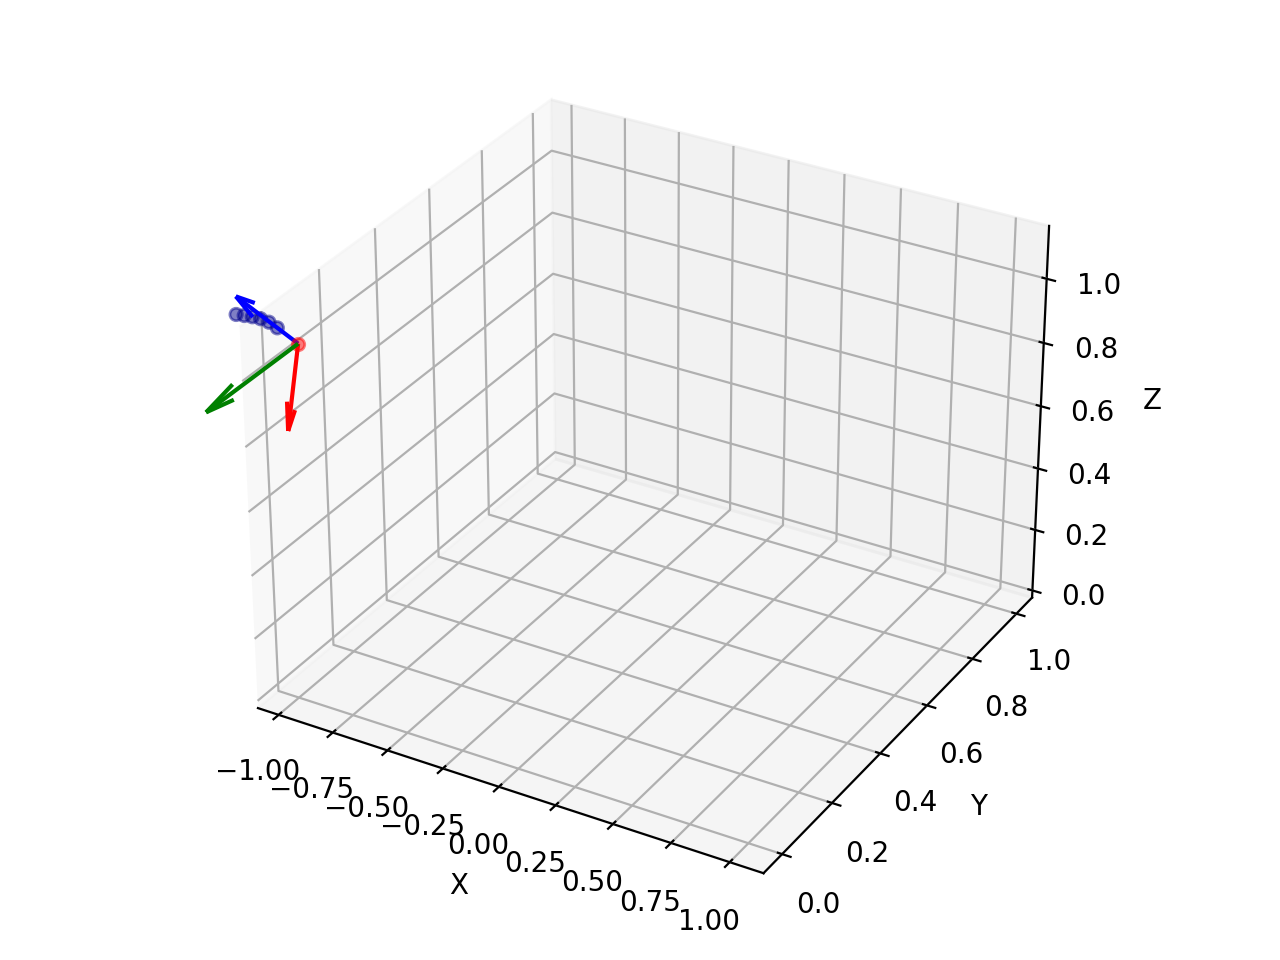

In [39]:
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
sc = ax.scatter([],[],[], c='darkblue', alpha=0.5)
sc_eef = ax.scatter([],[],[], c='red', alpha=0.5)

axes = []
def plot_pose(g):
    global axes, ax
    [axis.remove() for axis in axes]
    o = np.array([0, 0, 0, 1])
    u = np.array([1, 0, 0, 0]) * 0.3
    v = np.array([0, 1, 0, 0]) * 0.3
    w = np.array([0, 0, 1, 0]) * 0.3
    o_g, u_g, v_g, w_g = (g @ o)[:3], (g @ u)[:3], (g @ v)[:3], (g @ w)[:3]
    axes = [
        ax.quiver(*o_g, *u_g, color='red'),
        ax.quiver(*o_g, *v_g, color='green'),
        ax.quiver(*o_g, *w_g, color='blue')
    ]

def update(i):
    sc._offsets3d = (pts[i, :, 0], pts[i, :, 1], pts[i, :, 2])
    sc_eef._offsets3d = tuple(hand_poses[i][:3, 3].reshape(3, 1))
    #sc_eef._offsets3d = tuple(hand_poses[i].reshape(3, 1))
    plot_pose(hand_poses[i])

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
# ax.set_xlim(-0.3,0.3)
# ax.set_ylim(-0.3,0.3)
# ax.set_zlim(0,2)

ani = matplotlib.animation.FuncAnimation(fig, update, frames=horizon, interval=1)

plt.tight_layout()
plt.show()

## Tool Coords

<IPython.core.display.Javascript object>


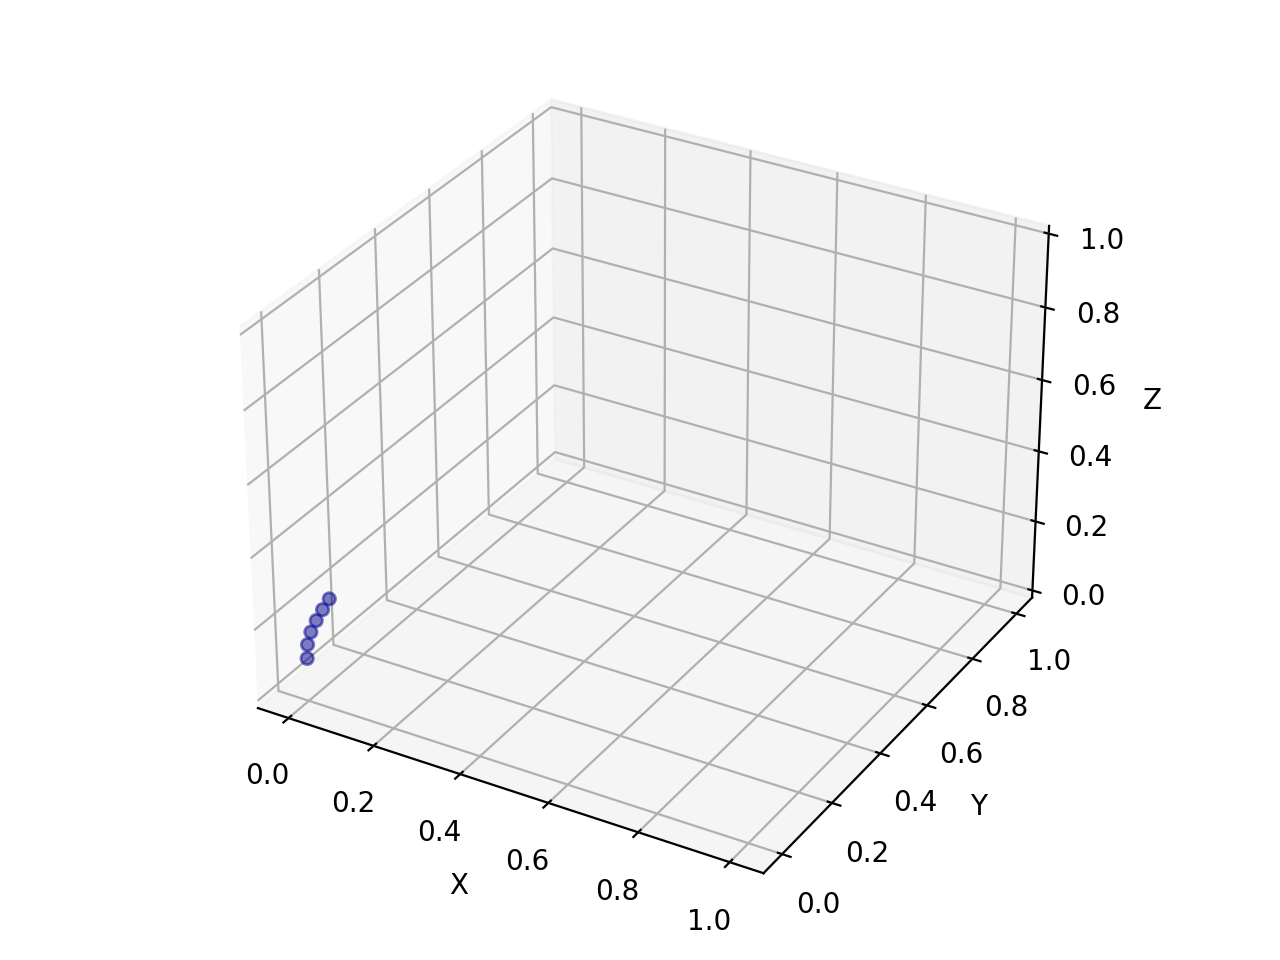

In [40]:
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
sc = ax.scatter([],[],[], c='darkblue', alpha=0.5)

def update(i):
    g_eef = hand_poses[i]
    pts_eef = np.linalg.inv(g_eef) @ np.hstack((pts[i], np.ones((6, 1)))).T
    sc._offsets3d = (pts_eef[0], pts_eef[1], pts_eef[2])

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
# ax.set_xlim(-0.3,0.3)
# ax.set_ylim(-0.3,0.3)
# ax.set_zlim(0,2)

ani = matplotlib.animation.FuncAnimation(fig, update, frames=horizon, interval=1)

plt.tight_layout()
plt.show()

# Mag Coords

<IPython.core.display.Javascript object>


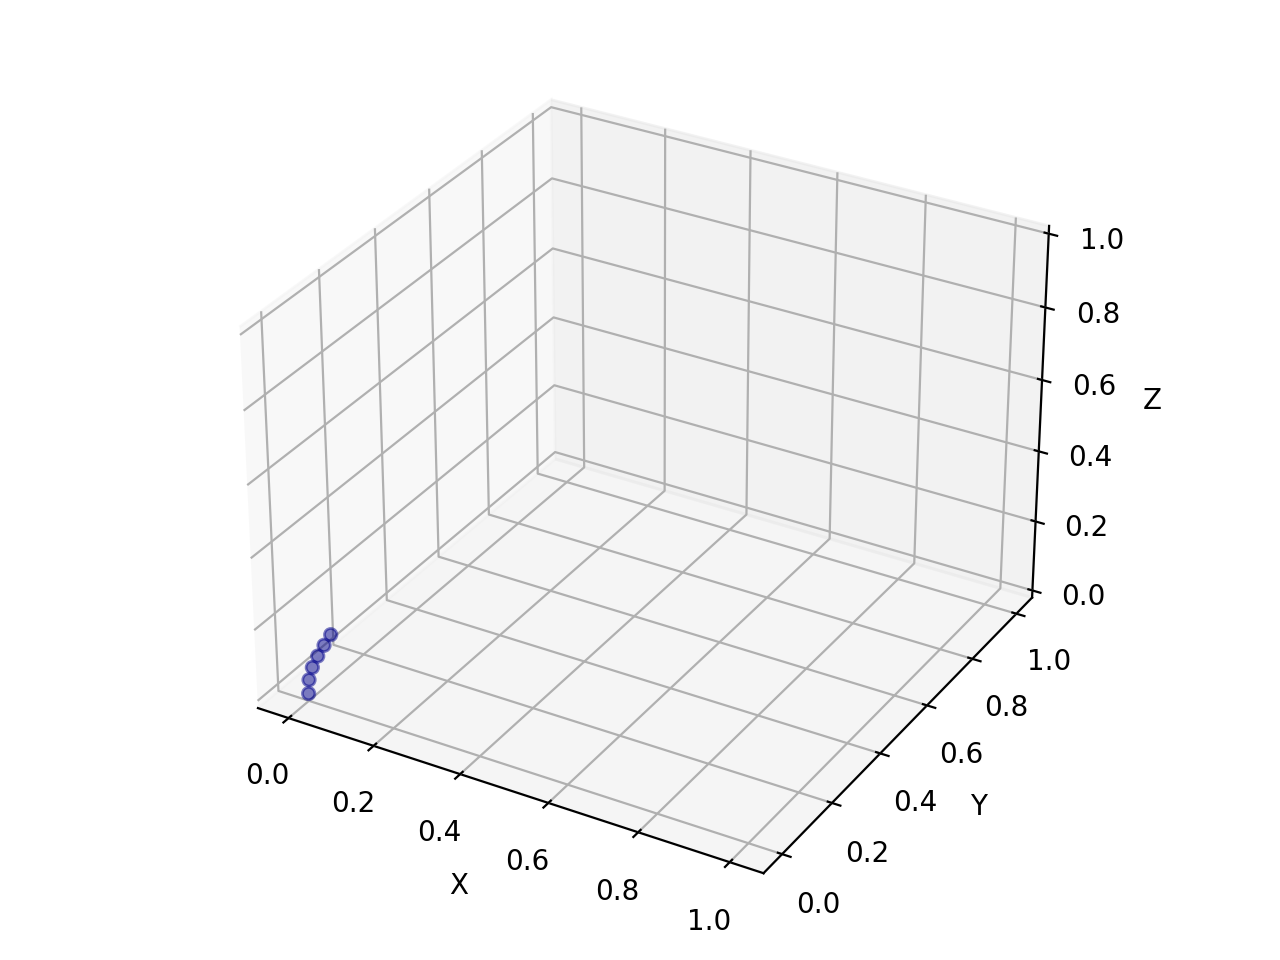

In [41]:
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
sc = ax.scatter([],[],[], c='darkblue', alpha=0.5)

def update(i):
    g_eef = hand_poses[i]
    pts_eef = np.linalg.inv(g_eef) @ np.hstack((pts[i], np.ones((6, 1)))).T
    pts_eef = (pts_eef.T - pts_eef[:, 0]).T
    sc._offsets3d = (pts_eef[0], pts_eef[1], pts_eef[2])

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
# ax.set_xlim(-0.3,0.3)
# ax.set_ylim(-0.3,0.3)
# ax.set_zlim(0,2)

ani = matplotlib.animation.FuncAnimation(fig, update, frames=horizon, interval=1)

plt.tight_layout()
plt.show()

# Data

In [42]:
from scipy.spatial.transform import Rotation

In [43]:
rvecs = np.load('rvecs_15.txt.npy', allow_pickle=True)
tvecs = np.load('tvecs_15.txt.npy', allow_pickle=True)

## Helpers

In [68]:
def split_vec(vec, tool=0):
    idx = np.where(vec[:, 0] == tool)[0][0]
    return vec[idx].reshape(1, 4), np.delete(vec, idx, axis=0)

def g(rvec, tvec):
    R = Rotation.from_rotvec(rvec).as_matrix()
    t = tvec.reshape(3, 1)
    return np.block([[R, t], [np.zeros(3), 1]]).reshape(4, 4)

def mag_coords(rvec, tvec, g_ttp=None, base=5):
    coords = tool_coords(rvec, tvec, g_ttp=g_ttp, indexed=True)
    idx = np.where(np.array(coords)[:, 0] == base)[0][0]
    return (np.array(coords) - coords[idx])[:, 1:]

def tool_coords(rvec, tvec, g_ttp=None, indexed=False):
    eef_tvec, _ = split_vec(tvec)
    eef_rvec, _ = split_vec(rvec)
    if g_ttp is None:
        g_ttp = np.eye(4)
    g_ct = g(eef_rvec[:, 1:], eef_tvec[:, 1:])
    g_tc = g_ttp @ np.linalg.inv(g_ct)
    coords = []
    for i in range(len(rvec)):
        if tvec[i, 0] == 0:
            continue
        g_ca = g(rvec[i, 1:], tvec[i, 1:])
        g_ta = g_tc @ g_ca
        if indexed:
            coords.append(np.concatenate(([tvec[i, 0]], g_ta[:3, 3])))
        else:
            coords.append(g_ta[:3, 3])
    return coords

def world_coords(rvec, tvec, eef_pose, g_ttp=None):
    eef_tvec, _ = split_vec(tvec)
    eef_rvec, _ = split_vec(rvec)
    g_ct = g(eef_rvec[:, 1:], eef_tvec[:, 1:])
    if g_ttp is None:
        g_ttp = np.eye(4)
    g_sc = eef_pose @ g_ttp @ np.linalg.inv(g_ct)
    coords = []
    for i in range(len(rvec)):
        if rvec[i, 0] == 0:
            continue
        g_ca = g(rvec[i, 1:], tvec[i, 1:])
        g_sa = g_sc @ g_ca
        coords.append(g_sa[:3, 3])
    return coords

## Scale

In [45]:
data_mag_len = np.mean([np.linalg.norm((split_vec(tvec, tool=1)[0] - split_vec(tvec, tool=5)[0])[0, 1:])
                        for tvec in tvecs])
sim_mag_len = np.mean([np.linalg.norm(pt[0] - pt[-1]) for pt in pts])
scale = sim_mag_len / data_mag_len
scale

1.4081595495215835

In [46]:
tvecs[:, :, 1:] *= scale

## Camera Coords

<IPython.core.display.Javascript object>


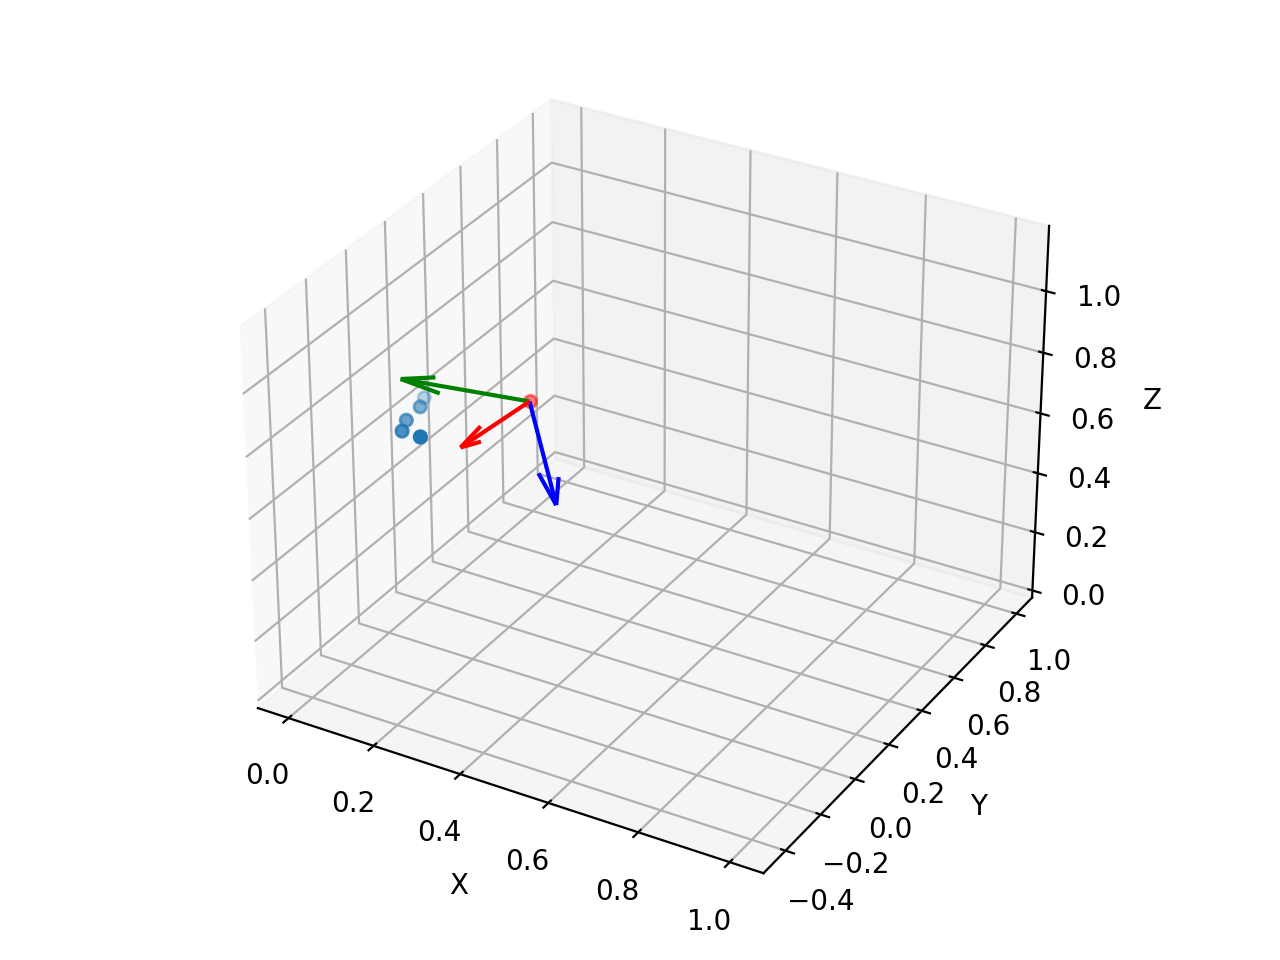

In [47]:
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
sc = ax.scatter([],[],[])
sc_eef = ax.scatter([],[],[], c='red', alpha=0.5)

axes = []
def plot_pose(g):
    global axes, ax
    [axis.remove() for axis in axes]
    o = np.array([0, 0, 0, 1])
    u = np.array([1, 0, 0, 0]) * 0.3
    v = np.array([0, 1, 0, 0]) * 0.3
    w = np.array([0, 0, 1, 0]) * 0.3
    o_g, u_g, v_g, w_g = (g @ o)[:3], (g @ u)[:3], (g @ v)[:3], (g @ w)[:3]
    axes = [
        ax.quiver(*o_g, *u_g, color='red'),
        ax.quiver(*o_g, *v_g, color='green'),
        ax.quiver(*o_g, *w_g, color='blue')
    ]

def update(i):
    eef_tvec, rem_tvecs = split_vec(tvecs[i])
    eef_rvec, rem_rvecs = split_vec(rvecs[i])
    sc._offsets3d = (rem_tvecs[:, 1], rem_tvecs[:, 2], rem_tvecs[:, 3])
    sc_eef._offsets3d = (eef_tvec[:, 1], eef_tvec[:, 2], eef_tvec[:, 3])
    g_eef = g(eef_rvec[:, 1:], eef_tvec[:, 1:])
    plot_pose(g_eef)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
# ax.set_xlim(-0.3,0.3)
# ax.set_ylim(-0.3,0.3)
# ax.set_zlim(0,2)

ani = matplotlib.animation.FuncAnimation(fig, update, frames=len(tvecs), interval=1)

plt.tight_layout()
plt.show()

## Tool Coords

In [48]:
g_ttp = np.array([
    [-1, 0, 0, 0],
    [0, 0, 1, 0],
    [0, 1, 0, 0],
    [0, 0, 0, 1]
])

<IPython.core.display.Javascript object>


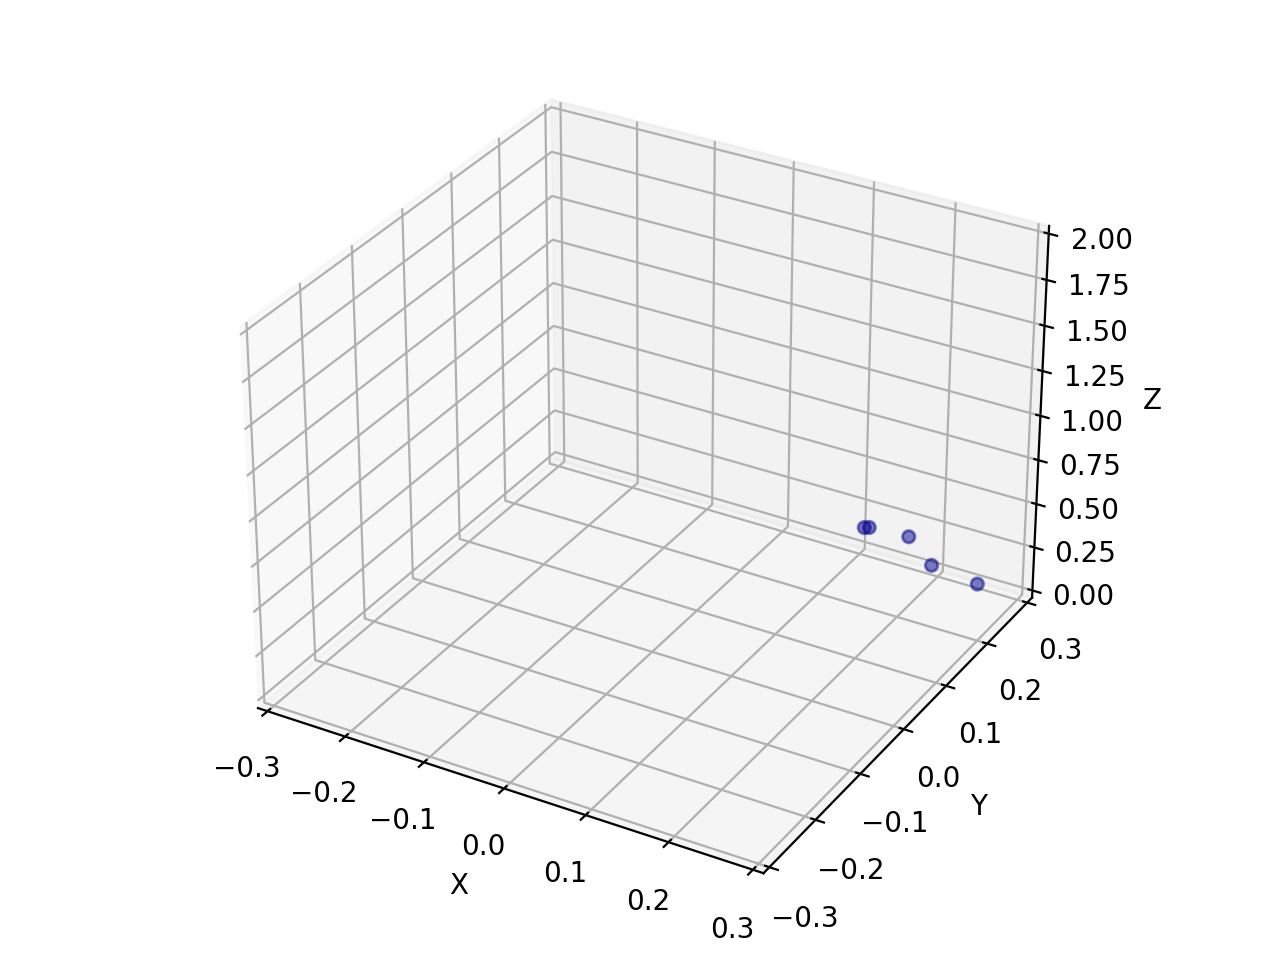

In [49]:
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
sc = ax.scatter([],[],[], c='darkblue', alpha=0.5)

def update(i):
    rec_coords = tool_coords(rvecs[i], tvecs[i], g_ttp=g_ttp)
    sc._offsets3d = tuple(np.array(rec_coords).T)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_xlim(-0.3,0.3)
ax.set_ylim(-0.3,0.3)
ax.set_zlim(0,2)

ani = matplotlib.animation.FuncAnimation(fig, update, frames=len(tvecs), interval=1)

plt.tight_layout()
plt.show()

## Mag Coords

<IPython.core.display.Javascript object>


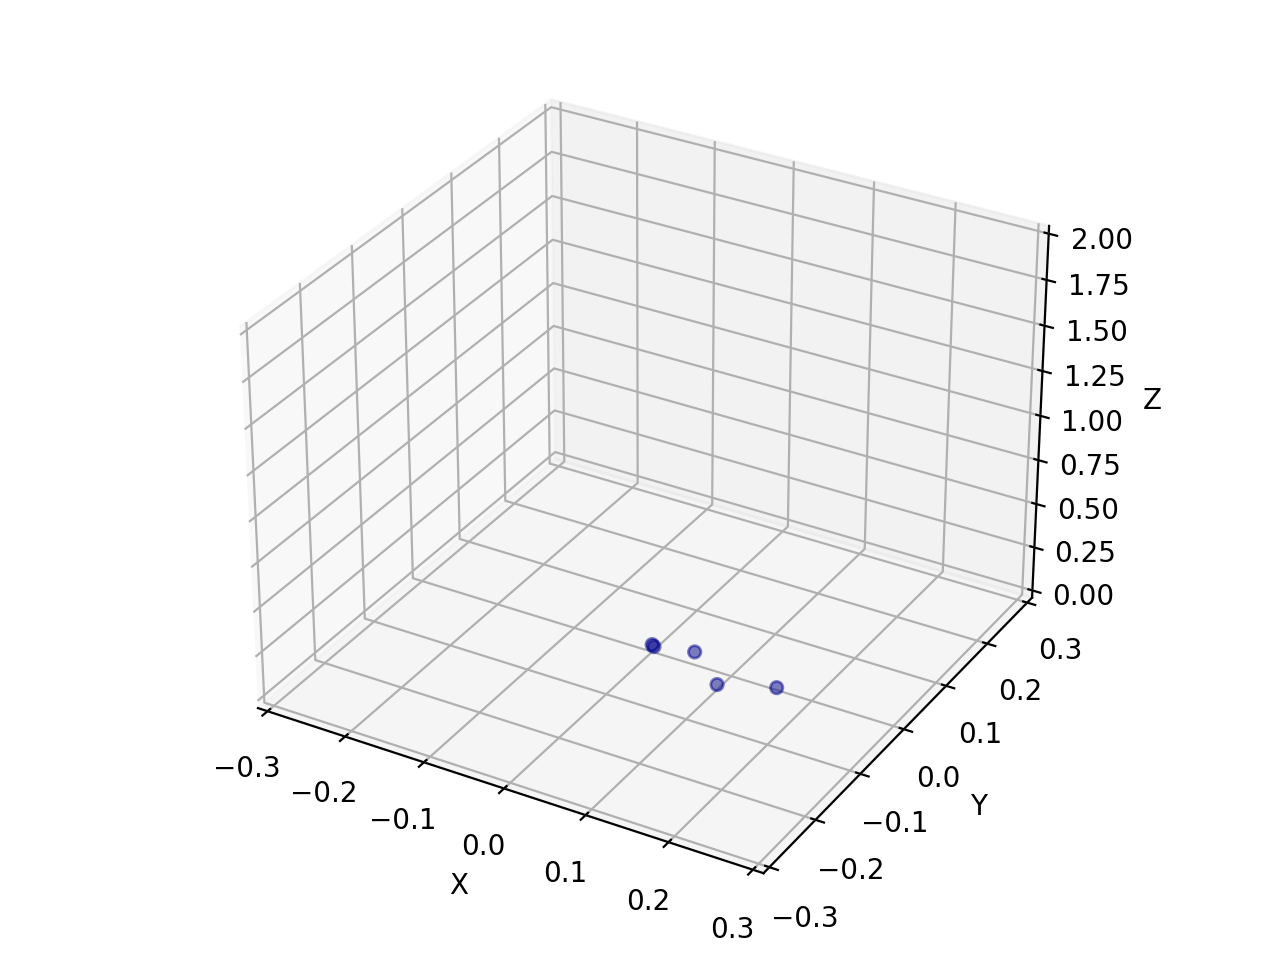

In [69]:
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
sc = ax.scatter([],[],[], c='darkblue', alpha=0.5)

def update(i):
    rec_coords = mag_coords(rvecs[i], tvecs[i], g_ttp=g_ttp)
    sc._offsets3d = tuple(np.array(rec_coords).T)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_xlim(-0.3,0.3)
ax.set_ylim(-0.3,0.3)
ax.set_zlim(0,2)

ani = matplotlib.animation.FuncAnimation(fig, update, frames=len(tvecs), interval=1)

plt.tight_layout()
plt.show()

# Data and Simulator

In [70]:
sampled_rvecs = rvecs[::6][:100]
sampled_tvecs = tvecs[::6][:100]

## World

<IPython.core.display.Javascript object>


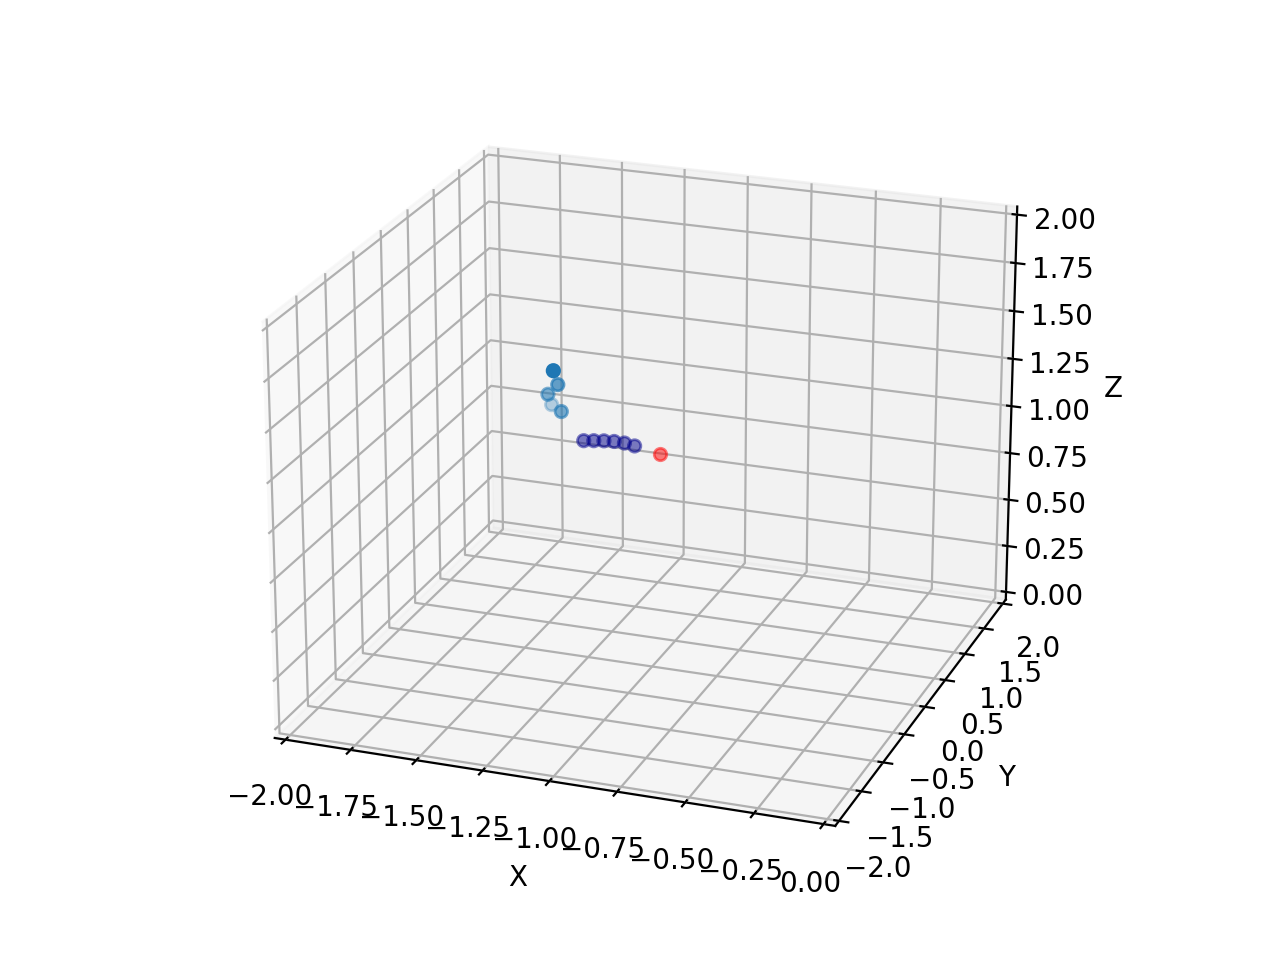

In [83]:
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
sc = ax.scatter([],[],[], c='darkblue', alpha=0.5)
sc_eef = ax.scatter([],[],[], c='red', alpha=0.5)
sc_rec = ax.scatter([],[],[])

def update(i):
    sc._offsets3d = (pts[i, :, 0], pts[i, :, 1], pts[i, :, 2])
    sc_eef._offsets3d = tuple(hand_poses[i][:3, 3].reshape(3, 1))
    rec_coords = world_coords(sampled_rvecs[i], sampled_tvecs[i], hand_poses[i], g_ttp=g_ttp)
    sc_rec._offsets3d = tuple(np.array(rec_coords).T)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_xlim(-2,0)
ax.set_ylim(-2,2)
ax.set_zlim(0,2)

ani = matplotlib.animation.FuncAnimation(fig, update, frames=horizon, interval=1)

plt.tight_layout()
plt.show()

## Mag

<IPython.core.display.Javascript object>


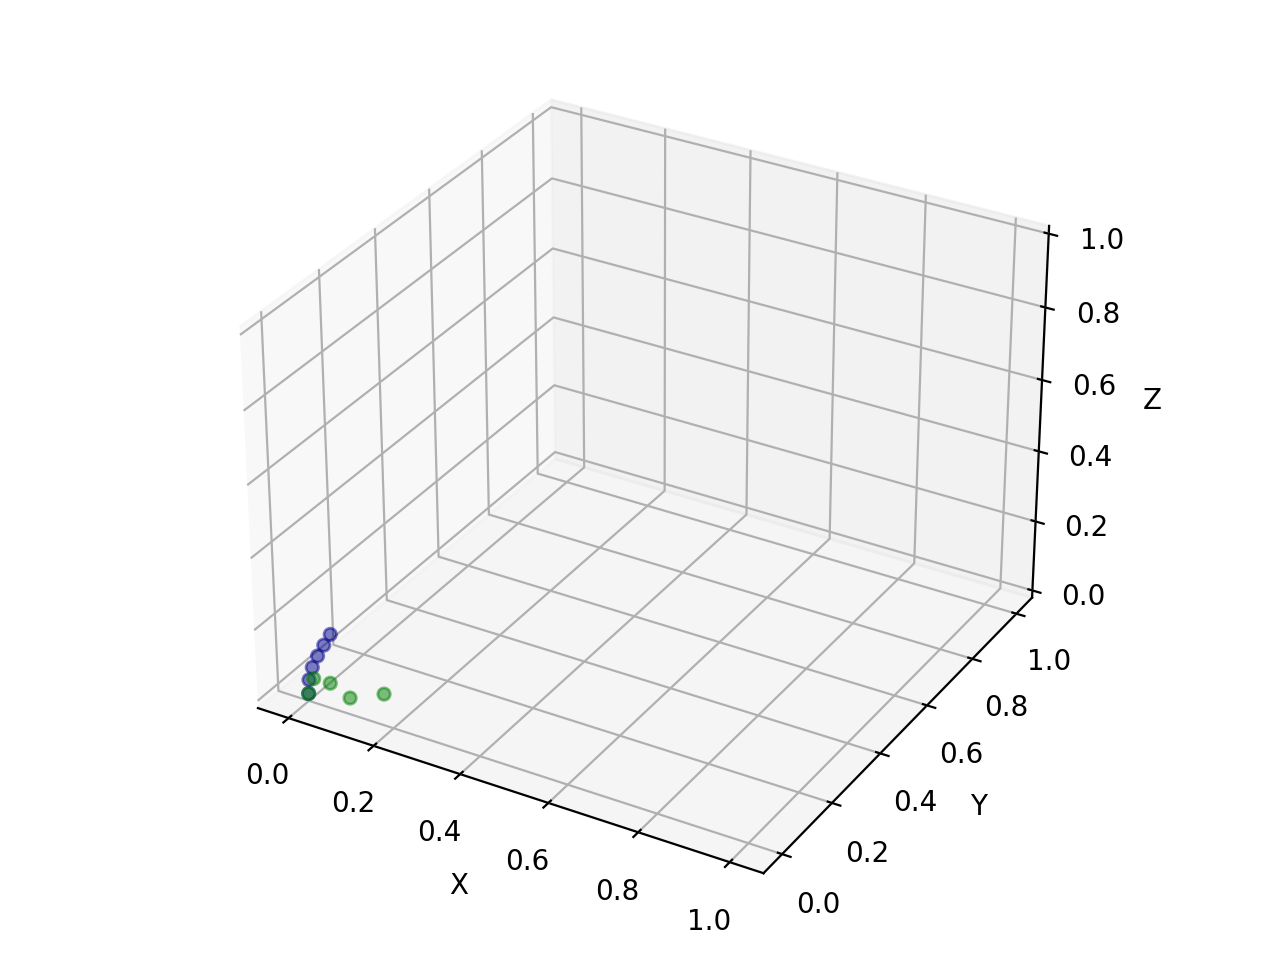

In [77]:
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
sc = ax.scatter([],[],[], c='darkblue', alpha=0.5)
sc_rec = ax.scatter([],[],[], c='green', alpha=0.5)

def update(i):
    g_eef = hand_poses[i]
    pts_eef = np.linalg.inv(g_eef) @ np.hstack((pts[i], np.ones((6, 1)))).T
    pts_eef = (pts_eef.T - pts_eef[:, 0]).T
    sc._offsets3d = (pts_eef[0], pts_eef[1], pts_eef[2])
    rec_coords = mag_coords(sampled_rvecs[i], sampled_tvecs[i], g_ttp=g_ttp)
    sc_rec._offsets3d = tuple(np.array(rec_coords).T)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
# ax.set_xlim(-1,1)
# ax.set_ylim(-1,1)
# ax.set_zlim(-1,1)

ani = matplotlib.animation.FuncAnimation(fig, update, frames=horizon, interval=1)

plt.tight_layout()
plt.show()

# Mag 2D

In [84]:
g_eef = hand_poses[0]
pts_eef = np.linalg.inv(g_eef) @ np.hstack((pts[0], np.ones((6, 1)))).T
pts_eef = (pts_eef.T - pts_eef[:, 0]).T
pts_eef

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  5.42101086e-18, -3.03576608e-18,
        -4.33680869e-18, -1.27935856e-17, -2.12503626e-17],
       [ 0.00000000e+00,  4.00000000e-02,  8.00000000e-02,
         1.20000000e-01,  1.60000000e-01,  2.00000000e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

<IPython.core.display.Javascript object>


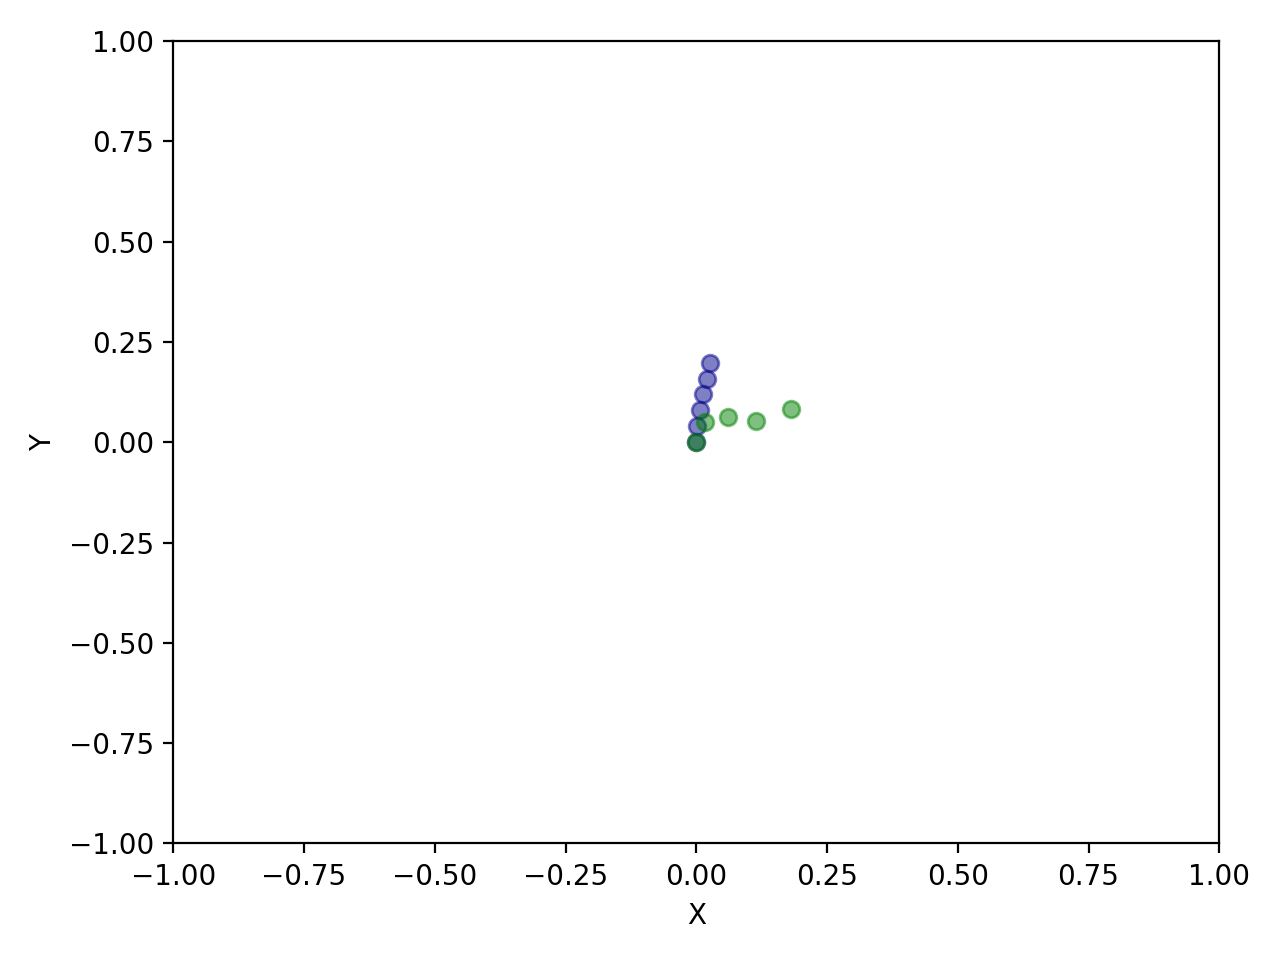

In [89]:
fig = plt.figure()
ax = fig.add_subplot(111)
sc = ax.scatter([],[], c='darkblue', alpha=0.5)
sc_rec = ax.scatter([],[], c='green', alpha=0.5)

def update(i):
    g_eef = hand_poses[i]
    pts_eef = np.linalg.inv(g_eef) @ np.hstack((pts[i], np.ones((6, 1)))).T
    pts_eef = (pts_eef.T - pts_eef[:, 0]).T
    sc.set_offsets(np.array([pts_eef[0], pts_eef[2]]).T)
    rec_coords = mag_coords(sampled_rvecs[i], sampled_tvecs[i], g_ttp=g_ttp)
    sc_rec.set_offsets(rec_coords.T[[0, 2]].T)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)

ani = matplotlib.animation.FuncAnimation(fig, update, frames=horizon, interval=1)

plt.tight_layout()
plt.show()